In [1]:
# ============================================================
# 📊 Sistema Inteligente para la Detección de URLs Maliciosas
# Autor: Yeho
# Curso: Interaccion persona - ordenador
# ============================================================

# =====================================
# 1. Importacion de librerias
# =====================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import string
import re
from sklearn.model_selection import train_test_split
from IPython.display import Markdown
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ipywidgets as widgets
from IPython.display import display

Markdown("""
# 📌 Planificación de Proyecto: Deteccion de URLs maliciosas

**Objetivo:** Diseñar un sistema de asistencia que ayude a detectar urls maliciosas,
siguiendo las fases de recopilación de datos, preprocesamiento, entrenamiento del modelo, evaluación, funcion de prediccion y widget interactivo

---
""")

# =====================================
# 2. obtencion de datasets desde una url publica
# =====================================
# Read the malicious_phish.csv file into df_malicious
df_malicious = pd.read_csv('http://yehovaldespino.com/static/malicious_phish.csv')

# Read the cleaned_topreal_urls.csv file into df_benign
df_benign = pd.read_csv('http://yehovaldespino.com/static/cleaned_topreal_urls.csv')


# Add a 'type' column to df_benign and set it to 'benign'
df_benign['type'] = 'benign'


# =====================================
# 3. combinacion de los dos datasets
# =====================================
# Concatenate the two DataFrames
df_combined = pd.concat([df_malicious, df_benign], axis=0)

# Drop rows with NaN in 'type' column
df_combined.dropna(subset=['type'], inplace=True)

# =====================================
# 4. extraccion de caracteristicas para distinguir urls maliciosas
# =====================================
df_combined['url_length'] = df_combined['url'].apply(len)
df_combined['num_dots'] = df_combined['url'].apply(lambda x: x.count('.'))
df_combined['num_hyphens'] = df_combined['url'].apply(lambda x: x.count('-'))
df_combined['num_underscores'] = df_combined['url'].apply(lambda x: x.count('_'))
df_combined['num_slashes'] = df_combined['url'].apply(lambda x: x.count('/'))
df_combined['num_equals'] = df_combined['url'].apply(lambda x: x.count('='))
df_combined['num_at'] = df_combined['url'].apply(lambda x: x.count('@'))
df_combined['num_and'] = df_combined['url'].apply(lambda x: x.count('&'))
df_combined['num_exclamation'] = df_combined['url'].apply(lambda x: x.count('!'))
df_combined['num_question'] = df_combined['url'].apply(lambda x: x.count('?'))
df_combined['num_percent'] = df_combined['url'].apply(lambda x: x.count('%'))
df_combined['num_plus'] = df_combined['url'].apply(lambda x: x.count('+'))
df_combined['num_asterisk'] = df_combined['url'].apply(lambda x: x.count('*'))
df_combined['num_comma'] = df_combined['url'].apply(lambda x: x.count(','))
df_combined['num_double_slash'] = df_combined['url'].apply(lambda x: x.count('//'))
df_combined['num_http_in_path'] = df_combined['url'].apply(lambda x: x[x.find('//')+2:].count('http'))
df_combined['hostname_length'] = df_combined['url'].apply(lambda x: len(re.findall(r'//([^/]+)/?', x)[0]) if re.findall(r'//([^/]+)/?', x) else 0)
df_combined['path_length'] = df_combined['url'].apply(lambda x: len(re.findall(r'//[^/]+(.*)', x)[0]) if re.findall(r'//[^/]+(.*)', x) else 0)
df_combined['query_length'] = df_combined['url'].apply(lambda x: len(re.findall(r'\?(.*)', x)[0]) if re.findall(r'\?(.*)', x) else 0)
df_combined['fragment_length'] = df_combined['url'].apply(lambda x: len(re.findall(r'#(.*)', x)[0]) if re.findall(r'#(.*)', x) else 0)


# Encode the 'type' column
label_encoder = LabelEncoder()
df_combined['type_encoded'] = label_encoder.fit_transform(df_combined['type'])

# Display the first few rows with the new encoded column
display(df_combined.head())

# Define the features and target variable
features = ['url_length', 'num_dots', 'num_hyphens', 'num_underscores', 'num_slashes',
            'num_equals', 'num_at', 'num_and', 'num_exclamation', 'num_question',
            'num_percent', 'num_plus', 'num_asterisk', 'num_comma', 'num_double_slash',
            'num_http_in_path', 'hostname_length', 'path_length', 'query_length',
            'fragment_length'] # Include features not explicitly removed
target = 'type_encoded'

X = df_combined[features]
y = df_combined[target]

# =====================================
# 5. Entrenamiento del modelo
# =====================================

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Instantiate an XGBoost classifier model
model = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), eval_metric='mlogloss') # Instantiate XGBoost

# Train the model
model.fit(X_train, y_train)

print("Model training complete.")


# Make predictions on the test data
y_pred = model.predict(X_test)


# =====================================
# 6. Evaluacion del modelo
# =====================================v
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted): {recall:.4f}')
print(f'F1-score (weighted): {f1:.4f}')

# =====================================
# 7. Funcion de prediccion
# =====================================

def predict_malicious(url):
    """
    Predicts whether a given URL is malicious or not using the trained model.

    Args:
        url: The input URL string.

    Returns:
        The predicted type of the URL (e.g., 'benign', 'phishing').
    """

    # Extract features from the input URL (excluding the features the user wanted to remove)
    url_features = {
        'url_length': len(url),
        'num_dots': url.count('.'),
        'num_hyphens': url.count('-'),
        'num_underscores': url.count('_'),
        'num_slashes': url.count('/'),
        'num_equals': url.count('='),
        'num_at': url.count('@'),
        'num_and': url.count('&'),
        'num_exclamation': url.count('!'),
        'num_question': url.count('?'),
        'num_percent': url.count('%'),
        'num_plus': url.count('+'),
        'num_asterisk': url.count('*'),
        'num_comma': url.count(','),
        'num_double_slash': url.count('//'),
        'num_http_in_path': url[url.find('//')+2:].count('http'),
        'hostname_length': len(re.findall(r'//([^/]+)/?', url)[0]) if re.findall(r'//([^/]+)/?', url) else 0,
        'path_length': len(re.findall(r'//[^/]+(.*)', url)[0]) if re.findall(r'//[^/]+(.*)', url) else 0,
        'query_length': len(re.findall(r'\?(.*)', url)[0]) if re.findall(r'\?(.*)', url) else 0,
        'fragment_length': len(re.findall(r'#(.*)', url)[0]) if re.findall(r'#(.*)', url) else 0,
    }

    # Create a pandas DataFrame from the extracted features, ensuring column names match training features
    features_for_prediction = ['url_length', 'num_dots', 'num_hyphens', 'num_underscores', 'num_slashes',
                               'num_equals', 'num_at', 'num_and', 'num_exclamation', 'num_question',
                               'num_percent', 'num_plus', 'num_asterisk', 'num_comma', 'num_double_slash',
                               'num_http_in_path', 'hostname_length', 'path_length', 'query_length',
                               'fragment_length']
    url_features_df = pd.DataFrame([url_features], columns=features_for_prediction)

    # Use the trained model to predict the class
    encoded_prediction = model.predict(url_features_df)

    # Decode the predicted value back to the original type label
    decoded_prediction = label_encoder.inverse_transform(encoded_prediction)

    return decoded_prediction[0]


# =====================================
# 8. Ejemplos de URLs
# =====================================
benign_url = "https://www.google.com"
malicious_url = "http://example.com/phishing-site"
ip_url = "http://192.168.1.1/login"
shortened_url = "https://bit.ly/3jR9zYn"
xss_url = "http://example.com/search?q=<script>alert('XSS')</script>"

print(f"Prediction for '{benign_url}': {predict_malicious(benign_url)}")
print(f"Prediction for '{malicious_url}': {predict_malicious(malicious_url)}")
print(f"Prediction for '{ip_url}': {predict_malicious(ip_url)}")
print(f"Prediction for '{shortened_url}': {predict_malicious(shortened_url)}")
print(f"Prediction for '{xss_url}': {predict_malicious(xss_url)}")

,url,type,url_length,num_dots,num_hyphens,num_underscores,num_slashes,num_equals,num_at,num_and,...,num_plus,num_asterisk,num_comma,num_double_slash,num_http_in_path,hostname_length,path_length,query_length,fragment_length,type_encoded
0,br-icloud.com.br,phishing,16,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,2,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,2,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,3,1,2,3,4,0,3,...,0,0,0,1,0,21,60,49,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,2,1,1,3,3,0,2,...,0,0,0,1,0,23,205,194,0,1


Model training complete.
Accuracy: 0.9208
Precision (weighted): 0.9178
Recall (weighted): 0.9208
F1-score (weighted): 0.9185
Prediction for 'https://www.google.com': phishing
Prediction for 'http://example.com/phishing-site': defacement
Prediction for 'http://192.168.1.1/login': defacement
Prediction for 'https://bit.ly/3jR9zYn': phishing
Prediction for 'http://example.com/search?q=<script>alert('XSS')</script>': phishing


In [2]:
import ipywidgets as widgets
from IPython.display import display
# =====================================
# 9. Widget interactivo
# =====================================

# Create a text input widget
url_input = widgets.Text(
    value='',
    placeholder='Enter a URL here',
    description='URL:',
    disabled=False
)

# Create a button widget
predict_button = widgets.Button(
    description='Predict URL Type'
)

# Create an output widget
output_area = widgets.Output()

# Define the function to call when the button is clicked
def on_button_click(b):
    with output_area:
        output_area.clear_output() # Clear previous output
        url = url_input.value
        if url:
            if url.startswith('http://') or url.startswith('https://'):
                prediction = predict_malicious(url)
                print(f"The URL '{url}' is predicted as: {prediction}")
            else:
                print("Please enter the URL including 'http://' or 'https://'.")
        else:
            print("Please enter a URL.")


# Link the button click event to the function
predict_button.on_click(on_button_click)

# Display the widgets
display(url_input, predict_button, output_area)

Text(value='', description='URL:', placeholder='Enter a URL here')

Button(description='Predict URL Type', style=ButtonStyle())

Output()

Confusion Matrix:
[[62250    75    17  1981]
 [  117 14075   138   270]
 [   64   310  4256   262]
 [ 3545   816   152  9501]]


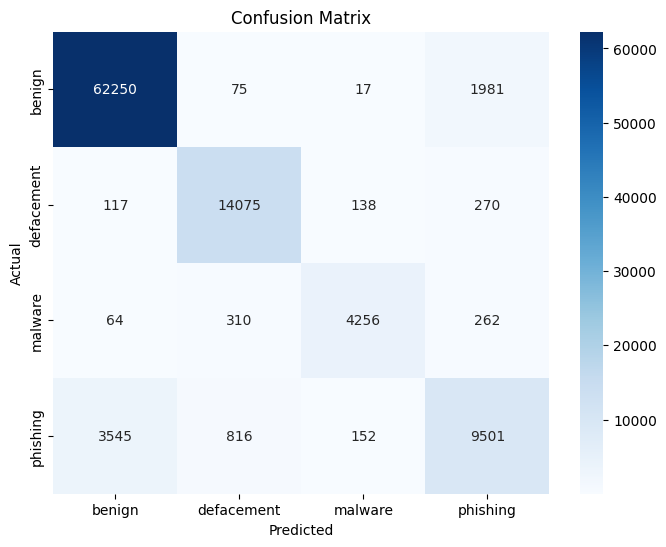

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =====================================
# 10. Calculo de matriz de confusion
# =====================================

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()